# Acquire

Let's acquire the parking citations data from our file.
1. Import libraries.
1. Load the dataset.
1. Display the shape and first/last 2 rows.
1. Display general infomation about the dataset - w/ the # of unique values in each column.
1. Display the number of missing values in each column.
1. Descriptive statistics for all numeric features.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
import folium
import unicodedata
import re
import json
import nltk

from requests import get
from time import time
from time import sleep
from random import randint
from IPython.core.display import clear_output
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

import speech_recognition as sr
import moviepy.editor as mp

# Insert path to the source folder.
sys.path.insert(1, 'src/')
import acquire
import prepare

# Filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

## Street Sweeper Citations
Data: [Los Angeles Parking Citations](https://www.kaggle.com/cityofLA/los-angeles-parking-citations)<br>
Load the dataset and filter for:
- Citations issued from 2017-01-01 to 2020-12-22.
- Street Sweeping violations - `Violation Description` == "NO PARK/STREET CLEAN"

In [2]:
df = acquire.get_sweep_data()

In [3]:
df.head(2)

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,...,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,Agency Description,Color Description,Body Style Description
0,4343388033,2018-10-25T00:00:00.000,1204.0,NaN,NaN,CA,201802.0,NaN,MNNI,PA,...,00472,54.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.477238e+06,1.854036e+06,NaN,NaN,NaN
1,4343388055,2018-10-25T00:00:00.000,1211.0,NaN,NaN,CA,201902.0,NaN,TOYT,PA,...,00472,54.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.477999e+06,1.851994e+06,NaN,NaN,NaN


In [4]:
df.tail(2)

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,...,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,Agency Description,Color Description,Body Style Description
1882462,4522167742,2020-12-22T00:00:00.000,1046.0,NaN,NaN,CA,202010.0,NaN,SUBA,PA,...,00300,53.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.380484e+06,1.895415e+06,53 - DOT - VALLEY,GREY,PASSENGER CAR
1882463,4523214220,2020-12-22T00:00:00.000,833.0,NaN,NaN,CA,NaN,NaN,JAGU,PA,...,00553,55.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.478186e+06,1.808237e+06,55 - DOT - SOUTHERN,BEIGE,PASSENGER CAR


In [5]:
df.describe()

,Issue time,Marked Time,Plate Expiry Date,VIN,Agency,Fine amount,Latitude,Longitude
count,1.882426e+06,0.0,1.719841e+06,0.0,1.882464e+06,1.882460e+06,1.882464e+06,1.882464e+06
mean,1.013076e+03,NaN,1.922022e+05,NaN,5.338664e+01,7.299998e+01,5.919254e+06,1.701929e+06
std,1.861187e+02,NaN,4.308395e+04,NaN,1.997974e+00,1.546120e-02,1.762232e+06,4.860292e+05
min,5.000000e+00,NaN,1.000000e+00,NaN,1.000000e+00,5.300000e+01,9.999900e+04,9.999900e+04
25%,8.420000e+02,NaN,2.018010e+05,NaN,5.100000e+01,7.300000e+01,6.424639e+06,1.825621e+06
50%,1.018000e+03,NaN,2.018100e+05,NaN,5.400000e+01,7.300000e+01,6.452519e+06,1.843891e+06
75%,1.209000e+03,NaN,2.019090e+05,NaN,5.500000e+01,7.300000e+01,6.472699e+06,1.859551e+06
max,2.355000e+03,NaN,9.201020e+05,NaN,5.800000e+01,7.300000e+01,6.513045e+06,1.940266e+06


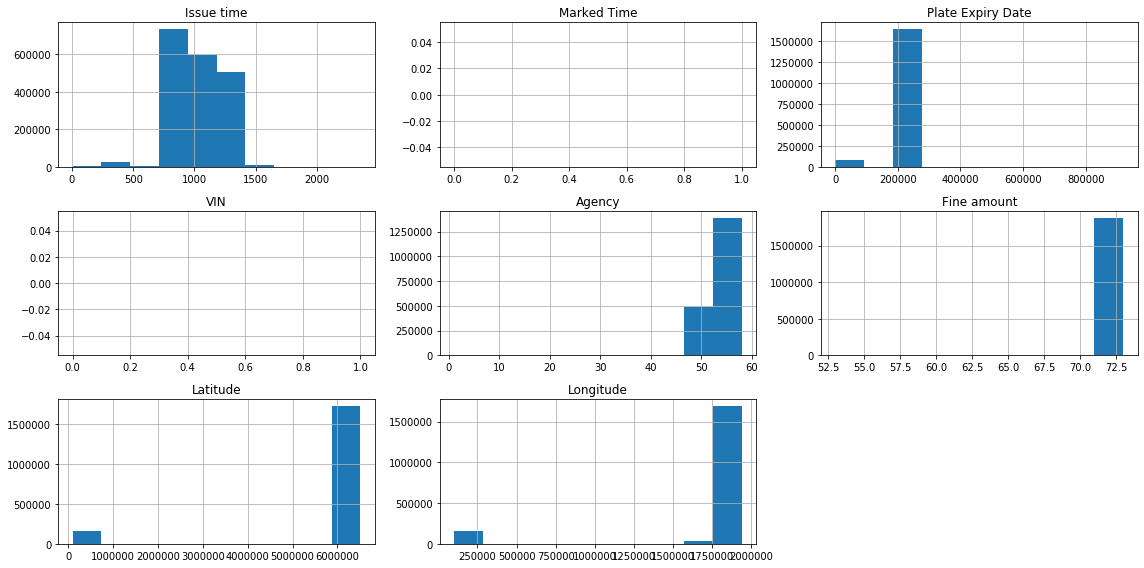

In [6]:
df.hist(figsize=(16, 8))
plt.tight_layout();

__Initial findings__
- `Issue time` and `Marked Time` are quasi-normally distributed. Note: Poisson Distribution
- It's interesting to see the distribution of our activity on earth follows a normal distribution.
- Agencies 50+ write the most parking citations.
- Most fine amounts are less than $100.00
- There are a few license plates that are null or invalid entrys.

## News Articles

- https://www.latimes.com/california/story/2020-03-16/los-angeles-parking-ticket-street-sweeping-coronavirus-covid19
- https://www.latimes.com/california/story/2020-10-15/street-sweeping-parking-enforcement-resumes-today
- https://abc7.com/society/las-resumed-parking-enforcement-prompts-outcry/7079278/

- https://www.theeastsiderla.com/site/about_the_eastsider/
- https://xtown.la/2020/10/15/parking-ticket-los-angeles/

In [7]:
df_news = acquire.get_news_articles()

In [8]:
remove_words = ['parking', 'vehicle', 'city', 'enforcement']

df_text = prepare.prep_article_data(df_news, column='article', add_to_stopwords=remove_words)

In [9]:
df_text

,title,article,stemmed,lemmatized,clean,words
0,Coronavirus: L.A. will temporarily stop ticket...,In an effort to help residents stuck at home d...,in an effort to help resid stuck at home dure ...,in an effort to help resident stuck at home du...,effort help resident stuck home coronavirus pa...,"[effort, help, resident, stuck, home, coronavi..."
1,"L.A. drivers, beware: Parking enforcement for ...",After nearly seven months of overlooking viola...,after nearli seven month of overlook violat be...,after nearly seven month of overlooking violat...,nearly seven month overlooking violation covid...,"[nearly, seven, month, overlooking, violation,..."
2,LA parking tickets: Resumed enforcement prompt...,LOS ANGELES (KABC) -- Following a relaxation o...,lo angel kabc follow a relax of park enforc du...,los angeles kabc following a relaxation of par...,los angeles kabc following relaxation due coro...,"[los, angeles, kabc, following, relaxation, du..."


# Prepare

- Remove spaces + capitalization in each column name
- Cast `Plate Expiry Date` to datetime data type.
- Cast `Issue Date` and `Issue Time` to datetime data types.
- Drop columns missing >=74.42\% of their values. 
- Drop missing values.

In [10]:
df_citations = prepare.prep_sweep_data(df)

In [11]:
df_citations.head()

,issue_date,issue_time,rp_state_plate,plate_expiry_date,make,body_style,color,location,route,agency,violation_code,violation_description,fine_amount,latitude,longitude,day_of_week,issue_year,issue_hour,issue_minute
0,2017-01-03,10:53:00,CA,2017-07-01,VOLK,PA,MR,2400 PATRICIA AVENUE,00108,51,80.69BS,NO PARK/STREET CLEAN,73.0,34.0452,-118.4190,Tuesday,2017,10,53
1,2017-01-03,11:03:00,CA,2016-07-01,TOYT,PA,BK,121 76TH PL E,00553,55,80.69BS,NO PARK/STREET CLEAN,73.0,33.9705,-118.2735,Tuesday,2017,11,3
2,2017-01-03,12:10:00,CA,2017-12-01,TOYT,PA,SL,151 78TH ST W,00553,55,80.69BS,NO PARK/STREET CLEAN,73.0,33.9689,-118.2750,Tuesday,2017,12,10
3,2017-01-03,12:14:00,CA,2017-09-01,HOND,PA,GY,247 78TH ST W,00553,55,80.69BS,NO PARK/STREET CLEAN,73.0,33.9689,-118.2771,Tuesday,2017,12,14
4,2017-01-03,12:15:00,CA,2017-03-01,HYUN,PA,RD,253 78TH ST W,00553,55,80.69BS,NO PARK/STREET CLEAN,73.0,33.9689,-118.2773,Tuesday,2017,12,15


# Exploratory Data Analysis

In [ ]:
sns.set_context('poster')

for i in range(0, 3):
    plt.figure(figsize=(10, 10))
    img = WordCloud(background_color='white').generate(df_text.clean[i])
    plt.imshow(img)
    plt.axis('off')

### Hypothesis Test 1

**Initial Query**
Was the amount of citations issued in October 2020 significantly greater than previous Octobers?

**Statistical Test**

$H_0$: There is no significant difference...

$H_a$: There is a significant difference...

# Conclusions